# Introduction to Deep Learning - Week 3: Kaggle Mini Project

# **HISTOPATHOLOGIC CANCER DETECTION**

# 1. Description of the Problem and Data

The goal of this project is to tackle a real-world medical imaging challenge through deep learning. Specifically, the task is to detect metastatic cancer in small histopathologic image patches.
In this binary classification task, I aim to build a Convolutional Neural Network (CNN) that can analyze image patches and determine whether they contain signs of cancer. Each image will be labeled either as positive (if cancerous tissue is present) or negative (if no tumor is detected).

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import tensorflow.keras as keras
import cv2
import time
import os
import itertools
import tensorflow as tf

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from collections import defaultdict
from tifffile import imread
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, BatchNormalization, Activation, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop

2025-05-19 10:09:02.384868: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747649342.678980      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747649342.751309      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


The dataset consists of thousands of RGB images in TIF format, each representing a small patch of a larger digital pathology scan. Each image is 96x96 pixels in size.

- Labels: the training labels are provided in a CSV file named *train_labels.csv*. Each row contains an image ID and a binary label (0 for negative, 1 for positive).

- Labeling Criteria: an image is labeled positive if the center 32x32 pixel region contains at least one pixel of tumor tissue. Tumor tissue in the outer region does not influence the label, although it is included to support models that use fully convolutional layers without zero-padding.

- Folders: the train folder contains the labeled images used for training, while the test folder includes unlabeled images for which predictions must be generated.

- File Size: the complete dataset download is approximately 7.76 GB.

In [2]:
# Load train and test data
dir_train = '/kaggle/input/histopathologic-cancer-detection/train'
dir_test = '/kaggle/input/histopathologic-cancer-detection/test'

# 2. Exploratory Data Analysis and Data Preprocessing

To begin exploring the dataset, we first examine the contents of the train_labels.csv file. This file contains 220,025 entries, each with two columns:

- *id*: the unique identifier for each image file (in .tif format),

- *label*: a binary value where 0 indicates a negative sample (no cancer) and 1 indicates a positive sample (presence of cancer).

This CSV file provides the ground truth for training our classification model.

In [3]:
# Examine train_labels file
df_trainlabels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
df_trainlabels.info()
df_trainlabels.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


To better understand the dataset, we take a visual sample of some of the pathology image patches: the first row of images shows examples labeled as positive, meaning cancerous tissue is present while the second row shows negative samples, which do not contain cancerous tissue.

It's important to note that the model will only consider the 32x32 pixel region at the center of each image when learning to make predictions. The outer areas of each image are included to allow for fully-convolutional models but are not used for labeling.

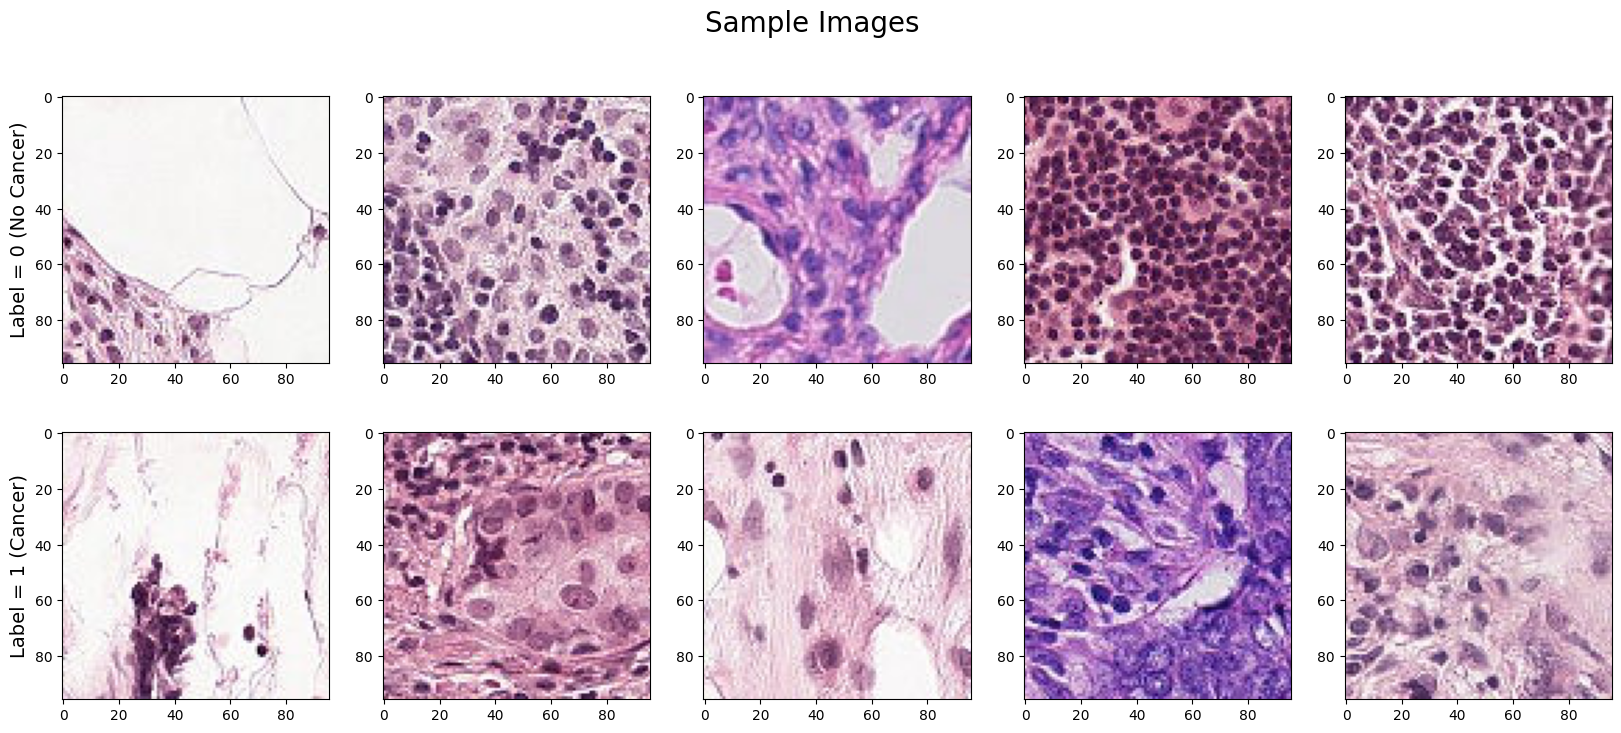

In [4]:
# Sample images
def makeSampleRow(row):
    for i, imageId in enumerate(df_trainlabels[df_trainlabels['label'] == row]['id'][:5]):
        path = os.path.join(dir_train, imageId)
        b, g, r = cv2.split(cv2.imread(path + '.tif', cv2.IMREAD_UNCHANGED))
        ax[row, i].imshow(cv2.merge([r, g, b]))
        
fig, ax = plt.subplots(2, 5, figsize = (20, 8))
fig.suptitle('Sample Images', fontsize = 20)

makeSampleRow(0)
makeSampleRow(1)

ax[0, 0].set_ylabel('Label = 0 (No Cancer)', fontsize='14')
ax[1, 0].set_ylabel('Label = 1 (Cancer)',  fontsize='14')
plt.show()

To assess the balance of our dataset, we plot a histogram of the label distribution.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

label
0    130908
1     89117
Name: count, dtype: int64

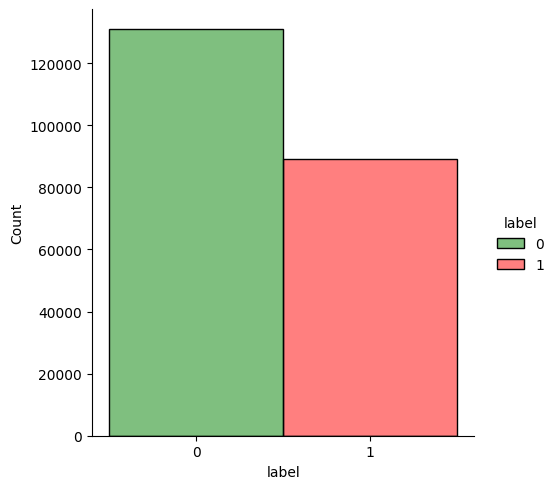

In [6]:
# Negative vs Positive labels histogram
df_trainlabels['label'] = df_trainlabels['label'].astype(str)
sns.displot(data=df_trainlabels, x='label', hue='label', palette={'0': 'green', '1': 'red'})
df_trainlabels['label'].value_counts()

This reveals a significant class imbalance: the dataset contains many more negative samples than positive ones. This is a common challenge in medical datasets, as true positive cases (in this case, cancer) are typically rarer.

In order to avoid a bias toward predicting negative outcomes, we perform an undersampling on the 0 label images.

In [7]:
## Undersampling
# Separate the two classes
df_positive = df_trainlabels[df_trainlabels['label'] == '1']
df_negative = df_trainlabels[df_trainlabels['label'] == '0']

# Drop 41,791 rows from the negative class
df_negative_reduced = df_negative.sample(n=len(df_positive), random_state=42)

# Combine with the positive class
df_balanced = pd.concat([df_positive, df_negative_reduced])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
df_balanced['label'].value_counts()

label
0    89117
1    89117
Name: count, dtype: int64

Now that we've examined the labels and image samples, it's time to prepare the whole dataset for model training.

In [8]:
# Count the number of train and test pictures
n_train = len(os.listdir(dir_train))
n_test = len(os.listdir(dir_test))
print("Training Images = ", n_train)
print("Test Images = ", n_test)

Training Images =  220025
Test Images =  57458


First, we append the .tif extension to each file ID to ensure that the image files can be correctly located and read. We then use Keras’ ImageDataGenerator to load the TIF images and handle preprocessing. As part of this process, we rescale the pixel values from their original 0–255 range to a normalized range between 0 and 1, which helps improve model performance.

Additionally, we split the training data into training and validation subsets. Given the large size of the dataset, we allocate 10% of the data for validation, which provides a good balance between training capacity and validation accuracy.

In [9]:
df_balanced['id'] = df_balanced['id'] + '.tif'
generator = ImageDataGenerator(rescale = 1.0 / 255, validation_split = 0.1)

With these steps complete, we can now generate our train and validation datasets.

In [10]:
batch_size, im_size = 256, (96, 96)

train_data = generator.flow_from_dataframe(
    dataframe = df_balanced,
    x_col = 'id',
    y_col = 'label',
    validate_filenames=False,
    directory = dir_train,
    subset = 'training',
    class_mode = 'binary',
    batch_size = batch_size,
    target_size = im_size)

Found 160411 non-validated image filenames belonging to 2 classes.


In [11]:
val_data = generator.flow_from_dataframe(
    dataframe = df_balanced,
    x_col = 'id', 
    y_col = 'label',
    validate_filenames=False,
    directory = dir_train,
    subset = "validation",
    class_mode = 'binary',
    batch_size = batch_size,
    target_size = im_size)

Found 17823 non-validated image filenames belonging to 2 classes.


# 3. Model Architecture and Analysis of the Results

# **Model 1**

The first model developed follows a straightforward VGG-style architecture, using a kernel size of 3x3 throughout the convolutional layers. This smaller kernel was chosen because it is more effective at capturing fine-grained details in the images—an essential factor, given that we are attempting to detect very small signs of metastatic cancer. Larger kernels tend to summarize information over a broader area, which could result in the loss of subtle but critical features.

For feature extraction, the model includes three repeated blocks consisting of two convolutional layers followed by a max-pooling layer (C-C-M). These blocks progressively increase in depth: the first uses 32 filters, the second uses 64, and the third uses 128 filters. All convolutional layers use the ReLU activation function to introduce non-linearity.

Following the convolutional blocks, the model transitions into a classification phase, which includes three dense (fully connected) layers, each also using ReLU activation. Finally, a fourth output dense layer is added, equipped with a sigmoid activation function to output probabilities for the binary classification task—indicating whether or not the image contains cancerous tissue.

In [13]:
def buildModel1():
    
    # Batches of size 32. Images of shape (96, 96, 3)
    image_shape = (96, 96, 3)
    model = Sequential()

    # 1) CNN as Feature Extractor
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding="same", activation = "relu", input_shape = image_shape))
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'))
    model.add(MaxPool2D(pool_size = (2, 2)))

    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    
    model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = "relu"))
    model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = "relu"))
    model.add(MaxPool2D(pool_size = (2, 2)))

    # 2) ANN for Binary Classification
    model.add(Flatten())
    model.add(Dense(units = 256, activation = 'relu'))
    model.add(Dense(units = 128, activation = 'relu'))
    model.add(Dense(units = 32, activation = 'relu'))
    
    # sigmoid activation for the output layer
    model.add(Dense(units = 1, activation = 'sigmoid'))    

    model.build()
    model.summary()
    
    return(model)

In [24]:
def plot_history(hist, start_time=0, end_time=0):
    model_accuracy = round((hist["accuracy"][model_epochs - 1]), 3)
    model_loss = round((hist["loss"][model_epochs - 1]), 3)
    model_val_accuracy = round((hist["val_accuracy"][model_epochs - 1]), 3)
    model_val_loss = round((hist["val_loss"][model_epochs - 1]), 3)
    model_train_time = round((end_time - start_time) / 60, 3)
    
    print("The final results for model:")
    print(f"\nTraining Time = {model_train_time} minutes")
    print(f"Accuracy = {model_accuracy}")
    print(f"Loss = {model_loss}")
    print(f"Validation Accuracy = {model_val_accuracy}")
    print(f"Validation Loss = {model_val_loss}\n\n")
    
    # Subplots initialization
    figure, axis = plt.subplots(2, 2)
    figure.tight_layout(pad = 2)
    figure.set_figheight(15)
    figure.set_figwidth(15)
    
    # Plot Training Accuracy Vs. Epoch
    testAccs = hist["accuracy"]
    epochs = [i for i in range(len(testAccs))]
    axis[0, 0].plot(epochs, testAccs)
    axis[0, 0].set_xlabel("Epoch")
    axis[0, 0].set_ylabel("Training Accuracy")
    axis[0, 0].set_title("Training Accuracy Vs. Epoch")
    
    # Plot Training Loss Vs. Epoch
    testLosses = hist["loss"]
    axis[0, 1].plot(epochs, testLosses)
    axis[0, 1].set_xlabel("Epoch")
    axis[0, 1].set_ylabel("Training Loss")
    axis[0, 1].set_title("Training Loss Vs. Epoch")
    
    # Plot Validation Accuracy Vs. Epoch
    testAccs = hist["val_accuracy"]
    epochs = [i for i in range(len(testAccs))]
    axis[1, 0].plot(epochs, testAccs)
    axis[1, 0].set_xlabel("Epoch")
    axis[1, 0].set_ylabel("Validation Accuracy")
    axis[1, 0].set_title("Validation Accuracy Vs. Epoch")
    
    # Plot Validation Loss Vs. Epoch
    testLosses = hist["val_loss"]
    axis[1, 1].plot(epochs, testLosses)
    axis[1, 1].set_xlabel("Epoch")
    axis[1, 1].set_ylabel("Validation Loss")
    axis[1, 1].set_title("Valiidation Loss Vs. Epoch")
    
    plt.show

In [15]:
model1 = buildModel1()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-19 10:11:15.626771: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 96, 96, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 94, 94, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 43, 43, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 21, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 19, 19, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 17, 17, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,421,473 (9.24 MB)

 Trainable params: 2,421,473 (9.24 MB)

 Non-trainable params: 0 (0.00 B)

**Model 1 Optimization**

The model is compiled using the Adam optimizer with its default learning rate of 0.001. The binary crossentropy loss function is used, as this is a standard choice for binary classification problems. The model is trained over 10 epochs.

In [16]:
model1_opt = Adam(learning_rate = 0.001)
model1_epochs = 10

startTime1 = time.time()
model1.compile(optimizer = model1_opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

history1 = model1.fit(train_data, validation_data = val_data, epochs = model1_epochs, steps_per_epoch = int(len(train_data)/5))
endTime1 = time.time()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 997s 8s/step - accuracy: 0.6175 - loss: 0.6314 - val_accuracy: 0.7782 - val_loss: 0.4744
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1072s 9s/step - accuracy: 0.7844 - loss: 0.4620 - val_accuracy: 0.7986 - val_loss: 0.4468
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1015s 8s/step - accuracy: 0.7920 - loss: 0.4507 - val_accuracy: 0.8013 - val_loss: 0.4387
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 998s 8s/step - accuracy: 0.8142 - loss: 0.4154 - val_accuracy: 0.8155 - val_loss: 0.4114
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1022s 8s/step - accuracy: 0.8231 - loss: 0.3960 - val_accuracy: 0.8380 - val_loss: 0.3670
Epoch 6/10
  2/125 ━━━━━━━━━━━━━━━━━━━━ 13:08 6s/step - accuracy: 0.8457 - loss: 0.3536

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


125/125 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.8399 - loss: 0.3795 - val_accuracy: 0.8388 - val_loss: 0.3724
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1106s 8s/step - accuracy: 0.8239 - loss: 0.4109 - val_accuracy: 0.8265 - val_loss: 0.3839
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1053s 8s/step - accuracy: 0.8395 - loss: 0.3649 - val_accuracy: 0.8467 - val_loss: 0.3439
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1012s 8s/step - accuracy: 0.8515 - loss: 0.3433 - val_accuracy: 0.8684 - val_loss: 0.3120
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 974s 8s/step - accuracy: 0.8675 - loss: 0.3099 - val_accuracy: 0.8500 - val_loss: 0.3333


**Model 1 Results**

The final results for model:

Training Time = 156.801 minutes
Accuracy = 0.866
Loss = 0.311
Validation Accuracy = 0.85
Validation Loss = 0.333




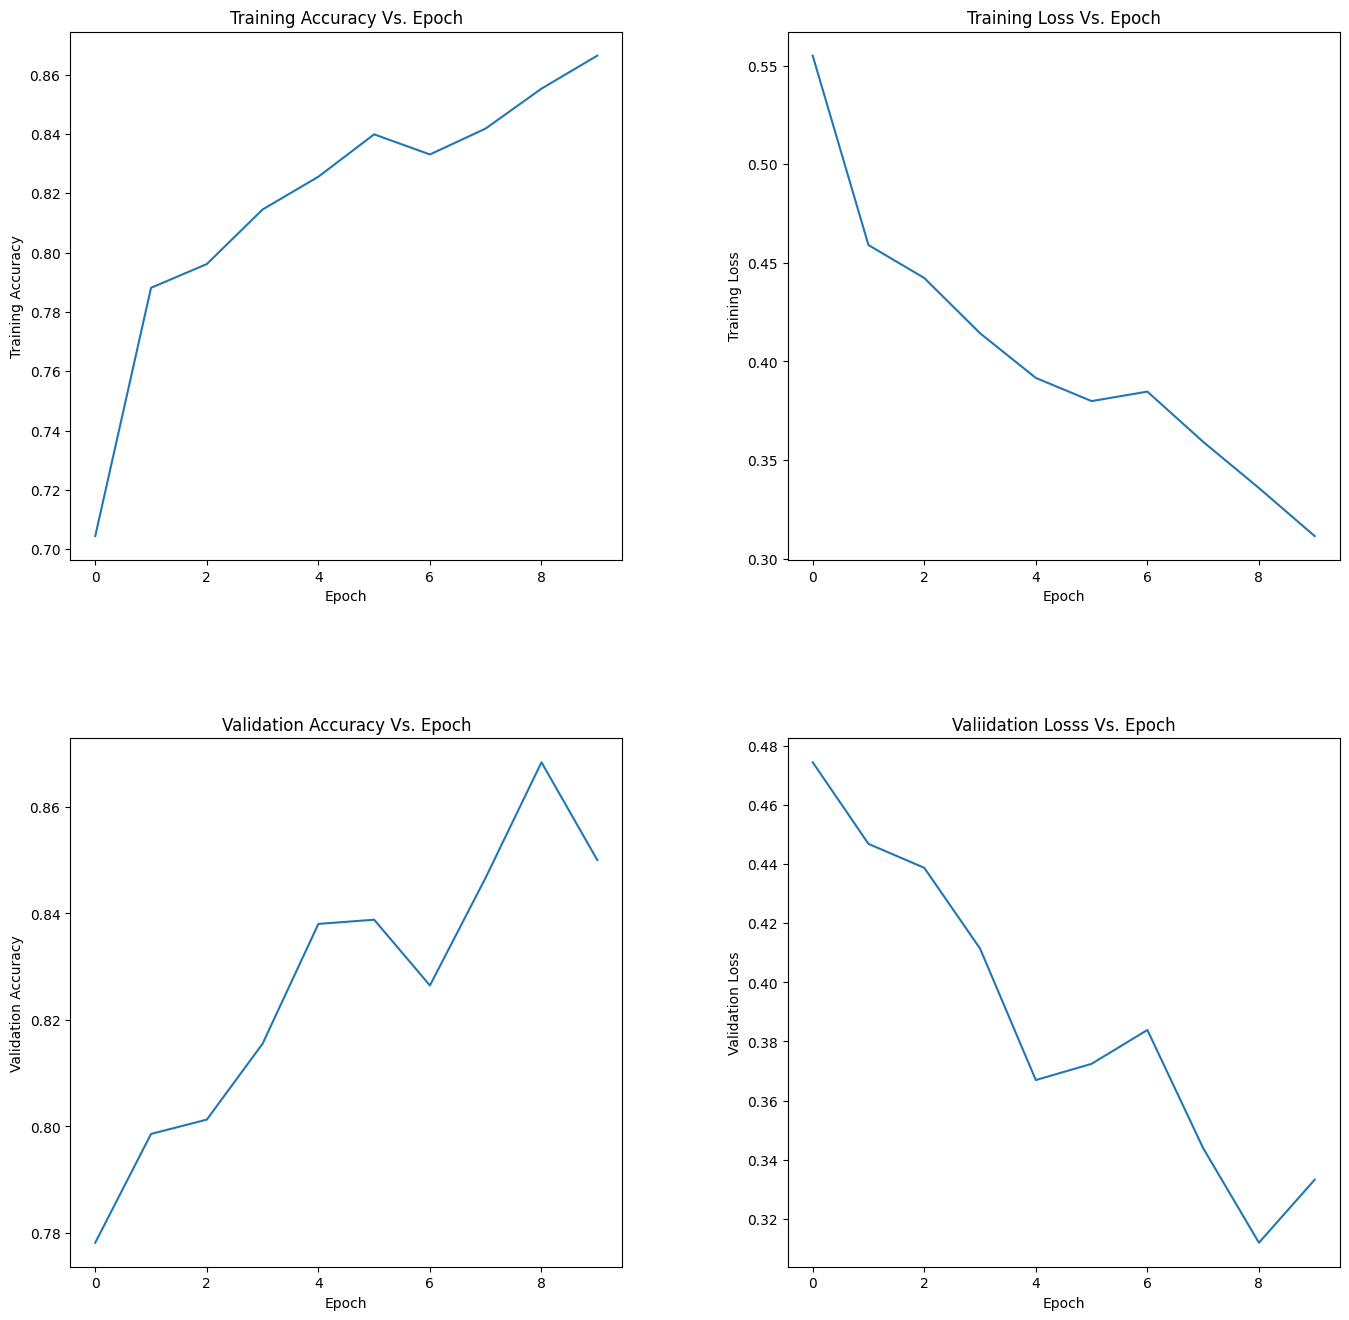

In [25]:
model_epochs=model1_epochs
plot_history(history1.history, startTime1, endTime1)

Model 1 provides a very solid starting point, achieving training and validation accuracies that are closely aligned respectively at 87% and 85%. This suggests that the model is generalizing well and not overfitting to the training data. While there is some fluctuation in the loss curves, this is to be expected, especially considering that the model was trained for only 10 epochs. With such a limited training duration, even minor variations can appear more pronounced and impact the overall learning trend.

# **Model 2**

The second model builds directly upon the structure of the first, introducing several enhancements aimed at improving generalization and training stability. One of the key modifications is the addition of **batch normalization layers** at the end of each convolutional block (C-C-M). These layers help stabilize and accelerate training by normalizing the outputs of the previous layers, and they can also act as a form of regularization, reducing the risk of overfitting.

To further improve regularization, **two dropout layers** have been incorporated into the fully connected (ANN) part of the model. The first dropout layer is placed immediately after the flattening operation, while the second is added just before the final output layer. These dropout layers randomly deactivate a fraction of neurons during training, encouraging the model to develop more robust features.

In addition, a **learning rate schedule** has been introduced to dynamically reduce the learning rate during training. This helps minimize oscillations or plateaus in performance toward the end of training, allowing for finer convergence.

Finally, a **callback list** has been implemented, which includes early stopping criteria. This allows the model to terminate training early if no significant improvement is observed in the validation performance. While this already contributes to efficiency, it will become particularly useful during future hyperparameter tuning, where many variations of the model may be trained.

In [26]:
def buildModel2():
    
    # Batches of size 32. Images of shape (96, 96, 3)
    image_shape = (96, 96, 3)
    model = Sequential()

    # 1) CNN as Feature Extractor
    model.add(Conv2D(32, kernel_size = 3, padding="same", activation = "relu", input_shape = image_shape))
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'))
    # Down-sampling of feature map size by a factor of 2 (i.e. 2x2 filter)
    model.add(MaxPool2D(pool_size = (2, 2)))
    # Normalization to avoid overfitting
    model.add(BatchNormalization(axis = -1)) 

    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    # Down-sampling of feature map size by a factor of 2 (i.e. 2x2 filter)
    model.add(MaxPool2D(pool_size = (2, 2)))
    # Normalization to avoid overfitting
    model.add(BatchNormalization(axis = -1)) 

    model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
    model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
    # Down-sampling of feature map size by a factor of 2 (i.e. 2x2 filter)
    model.add(MaxPool2D(pool_size = (2, 2)))
    # Normalization to avoid overfitting
    model.add(BatchNormalization(axis = -1)) 
    
    # 2) ANN for Binary Classification
    model.add(Flatten())
    # Dropout layer to set input units to 0 (to avoid overfitting)
    model.add(Dropout(0.25))
    model.add(Dense(256, activation = "relu"))
    model.add(Dense(128, activation = "relu"))
    # Dropout layer to randomly set input units to 0 (to avoid overfitting)
    model.add(Dropout(0.25))
    model.add(Dense(32, activation = "relu"))
    
    # sigmoid activation for the output layer
    model.add(Dense(1, activation = "sigmoid"))

    model.build()
    model.summary()
    
    return(model)

In [27]:
model2 = buildModel2()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 96, 96, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 94, 94, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 47, 47, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 43, 43, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 21, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 21, 21, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 19, 19, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 17, 17, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,369 (9.24 MB)

 Trainable params: 2,421,921 (9.24 MB)

 Non-trainable params: 448 (1.75 KB)

**Model 2 Optimization**

As with the first model, **Adam** is used as the optimizer in Model 2. However, instead of maintaining a fixed learning rate, this version incorporates a **learning rate scheduler with exponential decay**, allowing the learning rate to gradually decrease during training for more stable convergence. The **binary crossentropy** loss function is again employed, as it is well-suited for binary classification tasks. A **callbacks list** is also included to support features like early stopping, though given the relatively short training duration of 10 epochs, its impact in this instance is expected to be minimal.

In [28]:
# Learning rate schedule to prevent variance at the end of training
eta = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = eta, decay_steps = 10000, decay_rate = 0.9)
callbacks_list =  [tf.keras.callbacks.EarlyStopping(monitor="loss", patience = 10, mode = "min")]
model2_opt = Adam(learning_rate = lr_schedule)
model2_epochs = 10

In [29]:
model2.compile(optimizer = model2_opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
startTime2 = time.time()

history2 = model2.fit(train_data, validation_data = val_data, epochs = model2_epochs, callbacks = callbacks_list, steps_per_epoch = int(len(train_data) / 5))
endTime2 = time.time()


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1069s 8s/step - accuracy: 0.7477 - loss: 0.5490 - val_accuracy: 0.4979 - val_loss: 2.2435
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1057s 8s/step - accuracy: 0.8318 - loss: 0.3899 - val_accuracy: 0.4979 - val_loss: 3.1148
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1032s 8s/step - accuracy: 0.8553 - loss: 0.3476 - val_accuracy: 0.5233 - val_loss: 3.2638
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1036s 8s/step - accuracy: 0.8685 - loss: 0.3146 - val_accuracy: 0.6810 - val_loss: 0.8898
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1037s 8s/step - accuracy: 0.8786 - loss: 0.2920 - val_accuracy: 0.7063 - val_loss: 0.6674
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.8830 - loss: 0.2605 - val_accuracy: 0.7070 - val_loss: 0.7250
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1056s 8s/step - accuracy: 0.8900 - loss: 0.2691 - val_accuracy: 0.6681 - val_loss: 1.2372
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 1043s 8s/step - accuracy: 0.8987 - loss: 0.2556 - v

**Model 2 Results**

The final results for model:

Training Time = 161.302 minutes
Accuracy = 0.906
Loss = 0.235
Validation Accuracy = 0.846
Validation Loss = 0.385




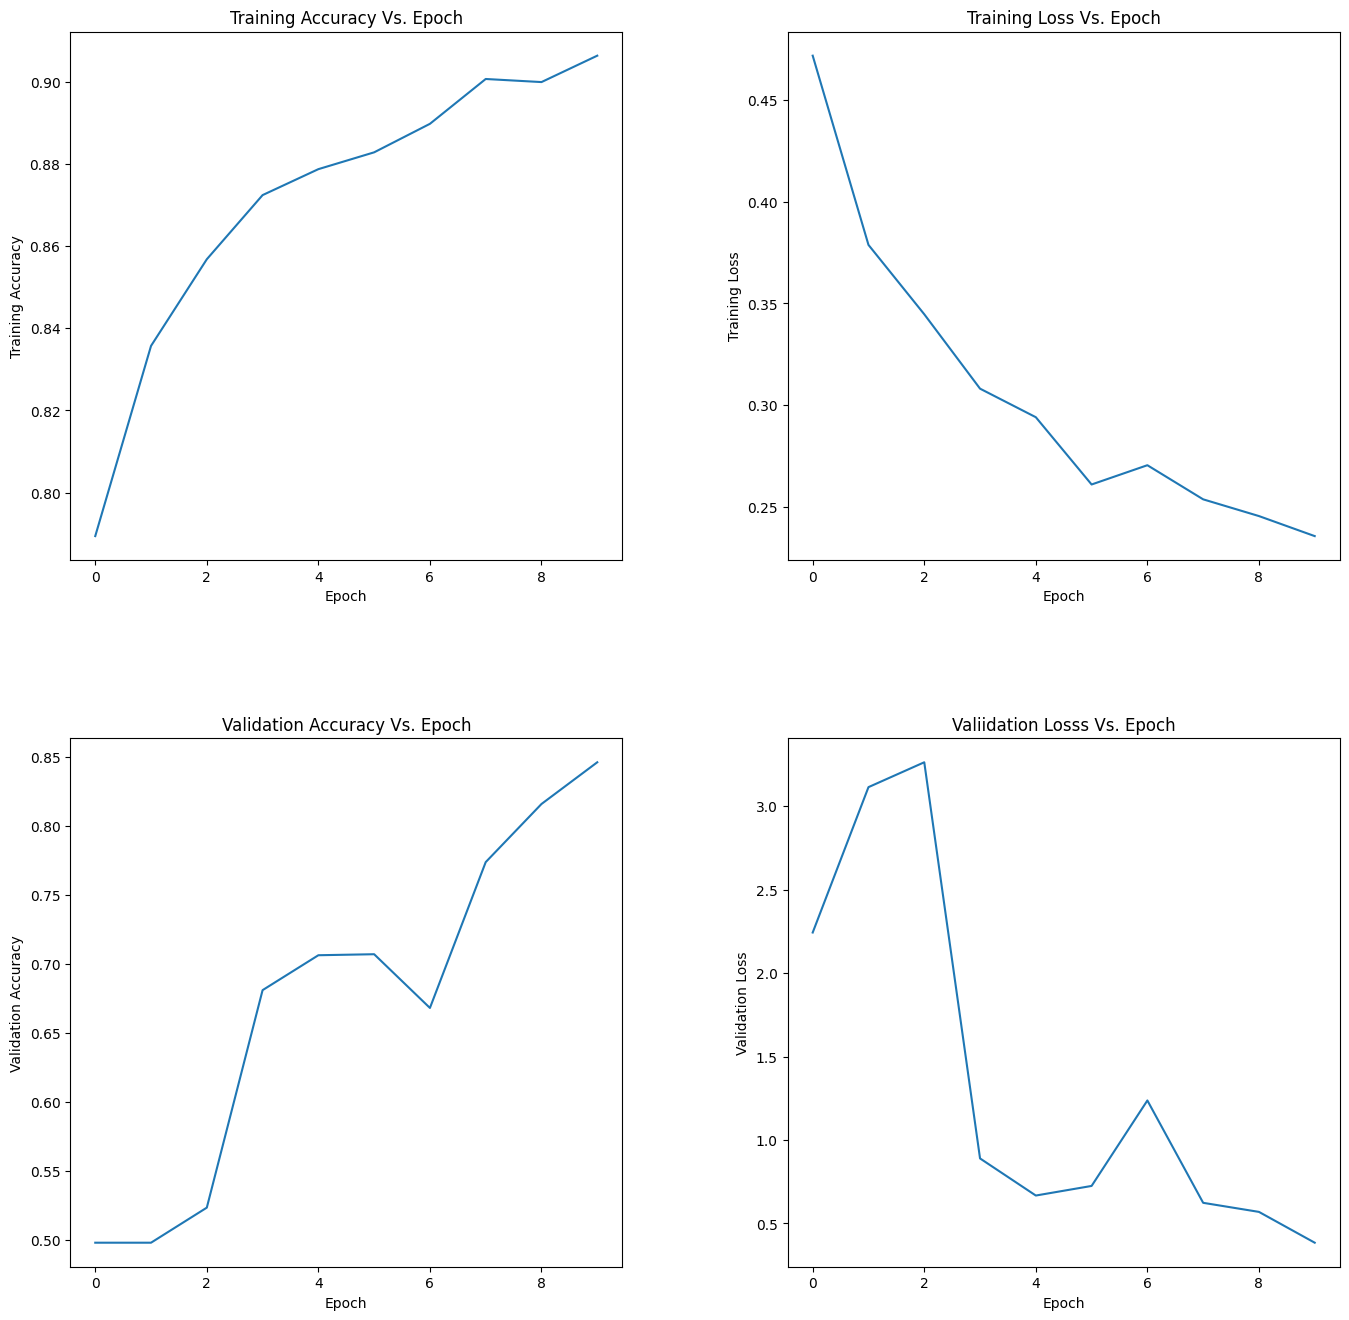

In [30]:
model_epochs=model2_epochs
plot_history(history2.history, startTime2, endTime2)

Model 2 shows some improvement over the first model, with the training accuracy increasing to 90% and the validation accuracy to 85%. These gains suggest that the enhancements—such as batch normalization and dropout—contributed to better learning and generalization. As with the previous model, there is still some jitter in the loss curves, but this is understandable given that training was again limited to just 10 epochs, where even minor fluctuations can appear more significant.

# **Model 3**

For the third model, the focus shifts to hyperparameter tuning, building upon the architecture established in Model 2. The primary objective here is to assess the impact of different values for a single key parameter: the initial learning rate (η), which determines the step size at which the model updates its weights during training.

In this model, RMSprop is used as the optimizer for all experiments. The learning rate is tuned across several values to investigate how this influences the model's training dynamics and accuracy. As in previous models, training is limited to a maximum of 10 epochs. The goal is to discover whether a carefully chosen learning rate can lead to better generalization or performance improvements over the earlier configurations.

In [31]:
eta_to_try = [0.001, 0.005, 0.01]
model3_epochs = 10

current_best_model = (None, 0)
current_best_history = None
current_best_hp = None

model_accuracies = list()
model3 = buildModel2()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 96, 96, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 94, 94, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 47, 47, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 43, 43, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 21, 21, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 21, 21, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 19, 19, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 17, 17, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,369 (9.24 MB)

 Trainable params: 2,421,921 (9.24 MB)

 Non-trainable params: 448 (1.75 KB)

In [32]:
# Loop through hyperparameters to find the best configuration
callbacks_list =  [tf.keras.callbacks.EarlyStopping(monitor="loss", patience = 10, mode = "min")]
startTime3 = time.time()
histories_list = []

for eta in eta_to_try:
    print("\n\nNow trying eta:", eta)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = eta, decay_steps = 10000, decay_rate = 0.9)
    model3.compile(optimizer = RMSprop(learning_rate = lr_schedule), loss = 'binary_crossentropy', metrics = ['accuracy'])

    this_history = model3.fit(train_data, validation_data = val_data, epochs = model3_epochs, steps_per_epoch = int(len(train_data) / 10), callbacks = callbacks_list)
    histories_list.append(this_history.history)
    if this_history.history["accuracy"][-1] > current_best_model[1]:
        current_best_model = (model3, this_history.history["accuracy"][-1])
        current_best_history = this_history.history
        current_best_hp = eta
        
endTime3 = time.time()
print("Total HP optimization time:", round((endTime3 - startTime3) / 60, 3), "minutes")



Now trying eta: 0.001
Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 589s 9s/step - accuracy: 0.6532 - loss: 1.3069 - val_accuracy: 0.4979 - val_loss: 1.3156
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 583s 9s/step - accuracy: 0.7844 - loss: 0.4917 - val_accuracy: 0.5058 - val_loss: 1.6158
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 639s 10s/step - accuracy: 0.8141 - loss: 0.4269 - val_accuracy: 0.4979 - val_loss: 1.8062
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 583s 9s/step - accuracy: 0.8227 - loss: 0.4016 - val_accuracy: 0.4983 - val_loss: 2.3463
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 642s 10s/step - accuracy: 0.8434 - loss: 0.3731 - val_accuracy: 0.5721 - val_loss: 1.2857
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 583s 9s/step - accuracy: 0.8447 - loss: 0.3549 - val_accuracy: 0.6102 - val_loss: 1.3723
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 580s 9s/step - accuracy: 0.8559 - loss: 0.3397 - val_accuracy: 0.6782 - val_loss: 0.6496
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 581s 9s/step - accuracy: 0.8535 - loss: 0.3345 

**Model 3 Results**

The final results for model:

Training Time = 0.0 minutes
Accuracy = 0.871
Loss = 0.31
Validation Accuracy = 0.747
Validation Loss = 0.544


The final results for model:

Training Time = 0.0 minutes
Accuracy = 0.855
Loss = 0.337
Validation Accuracy = 0.628
Validation Loss = 0.721


The final results for model:

Training Time = 0.0 minutes
Accuracy = 0.87
Loss = 0.32
Validation Accuracy = 0.502
Validation Loss = 1.703




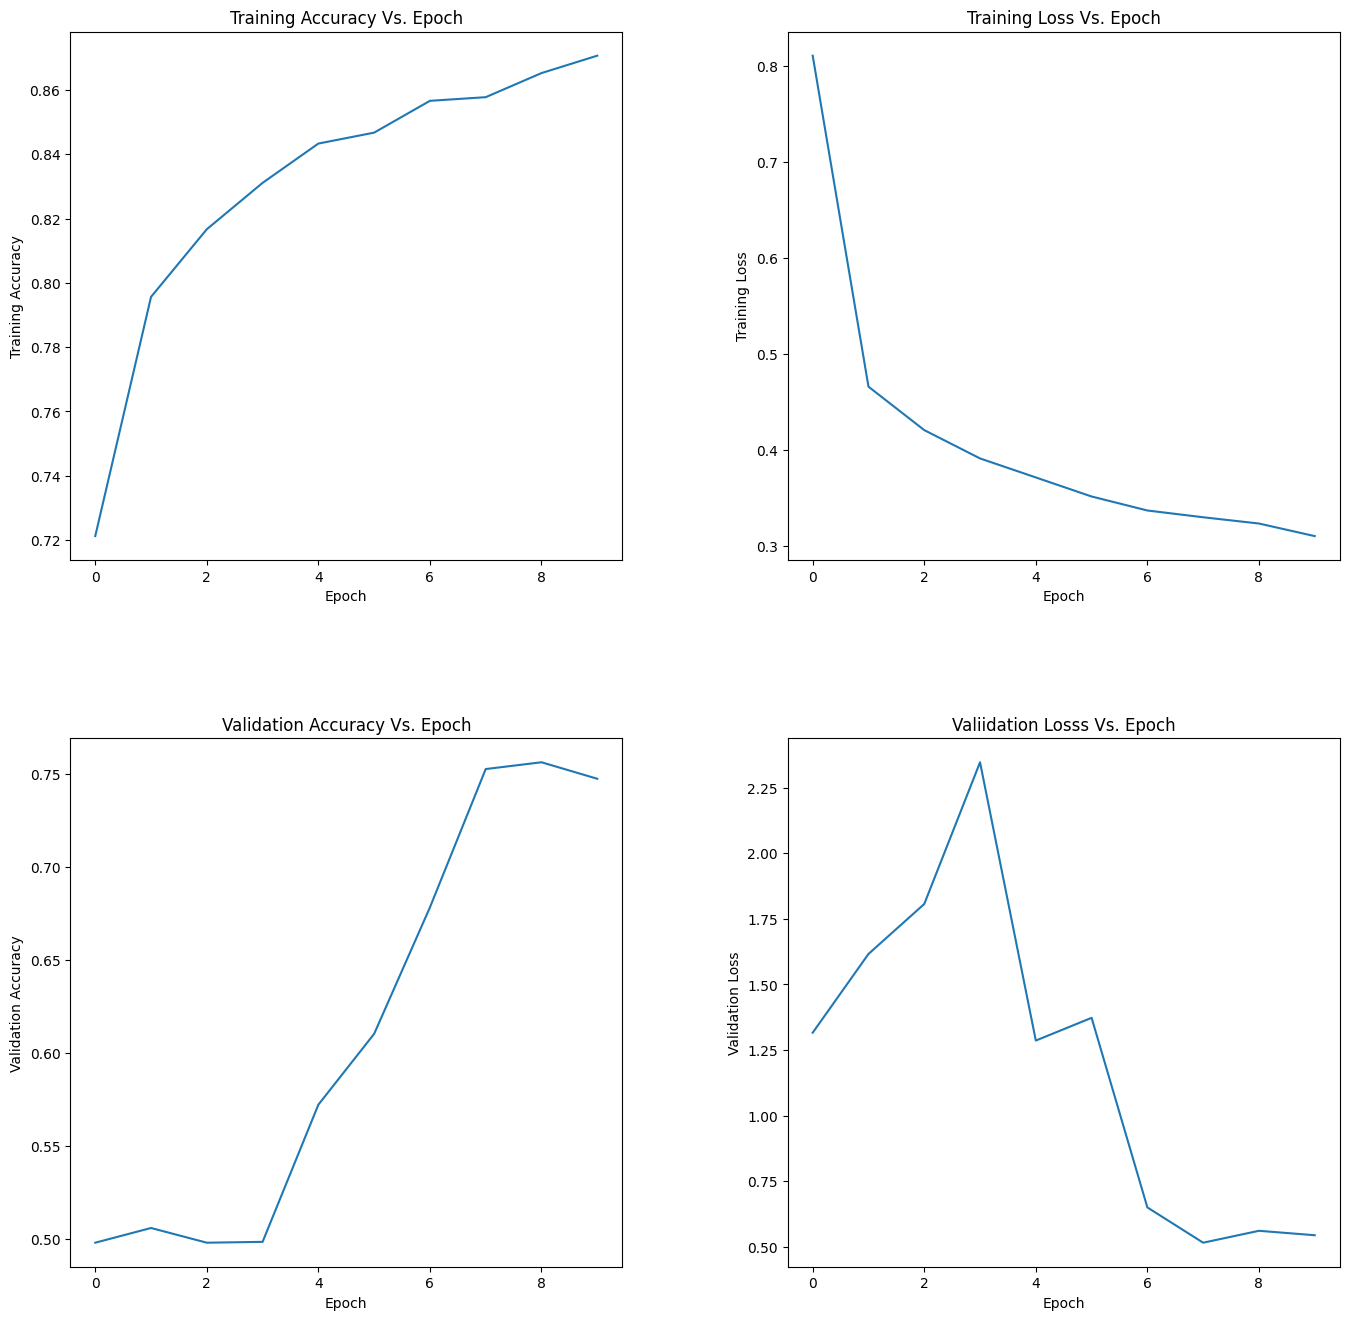

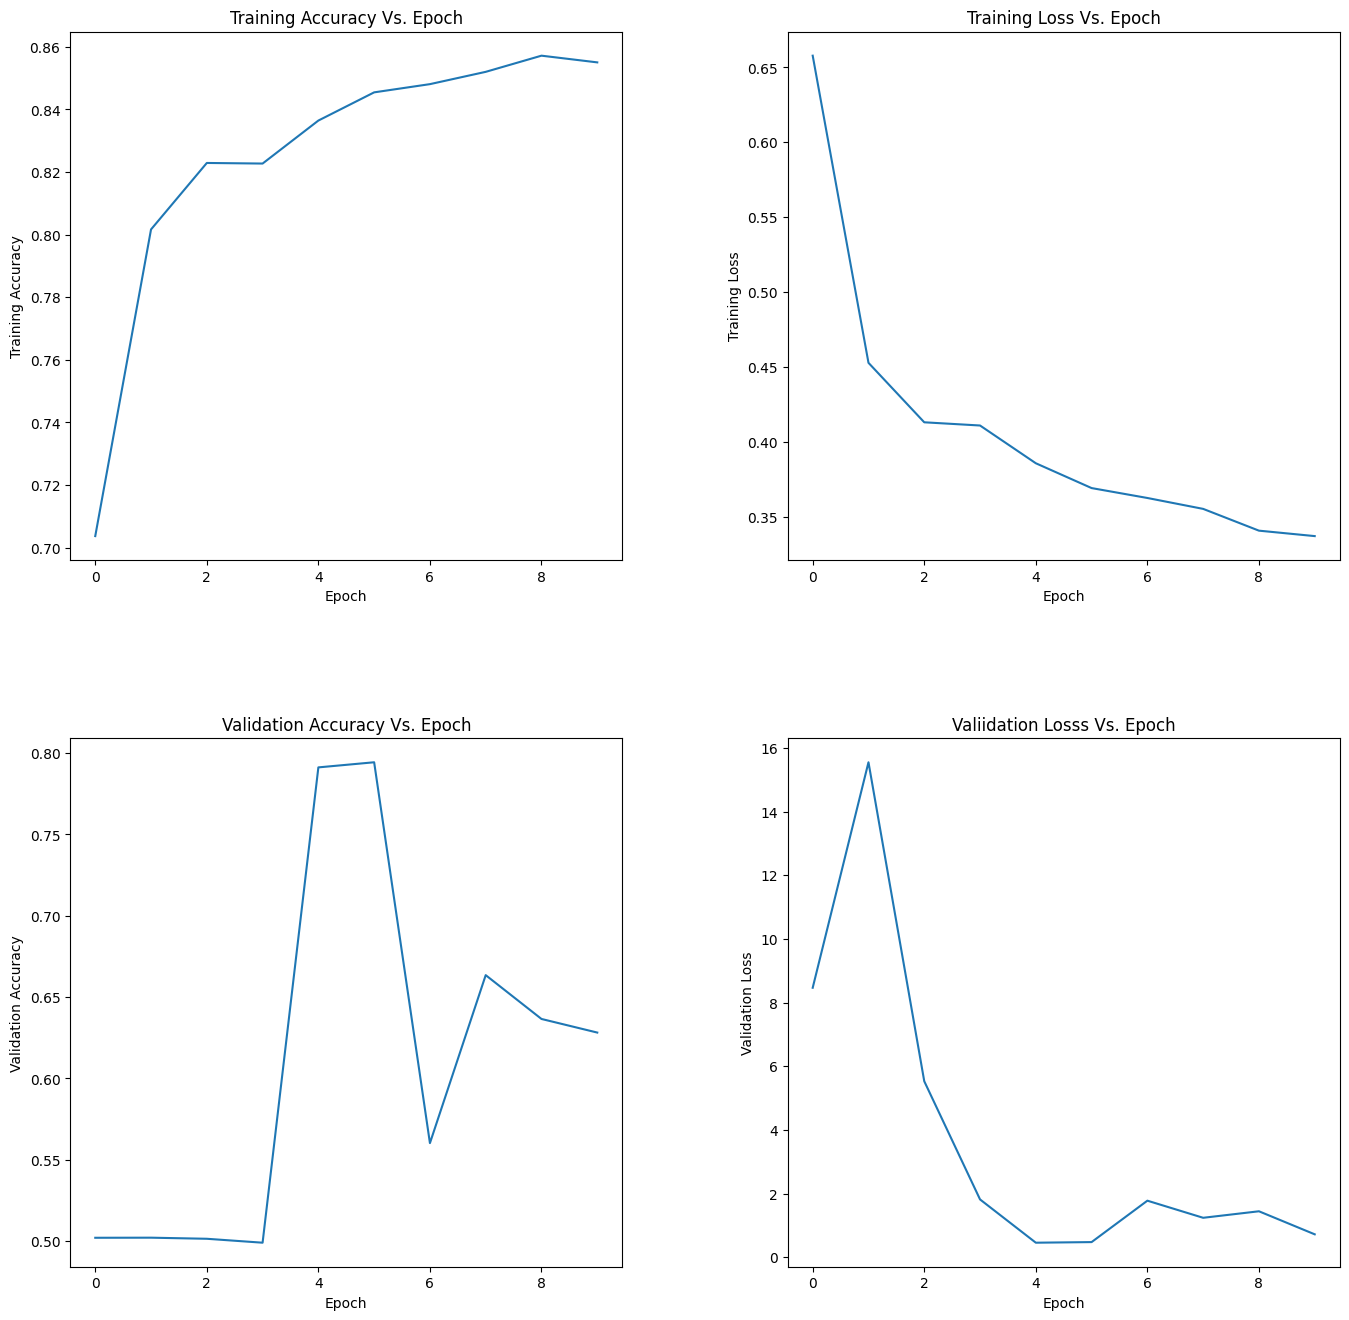

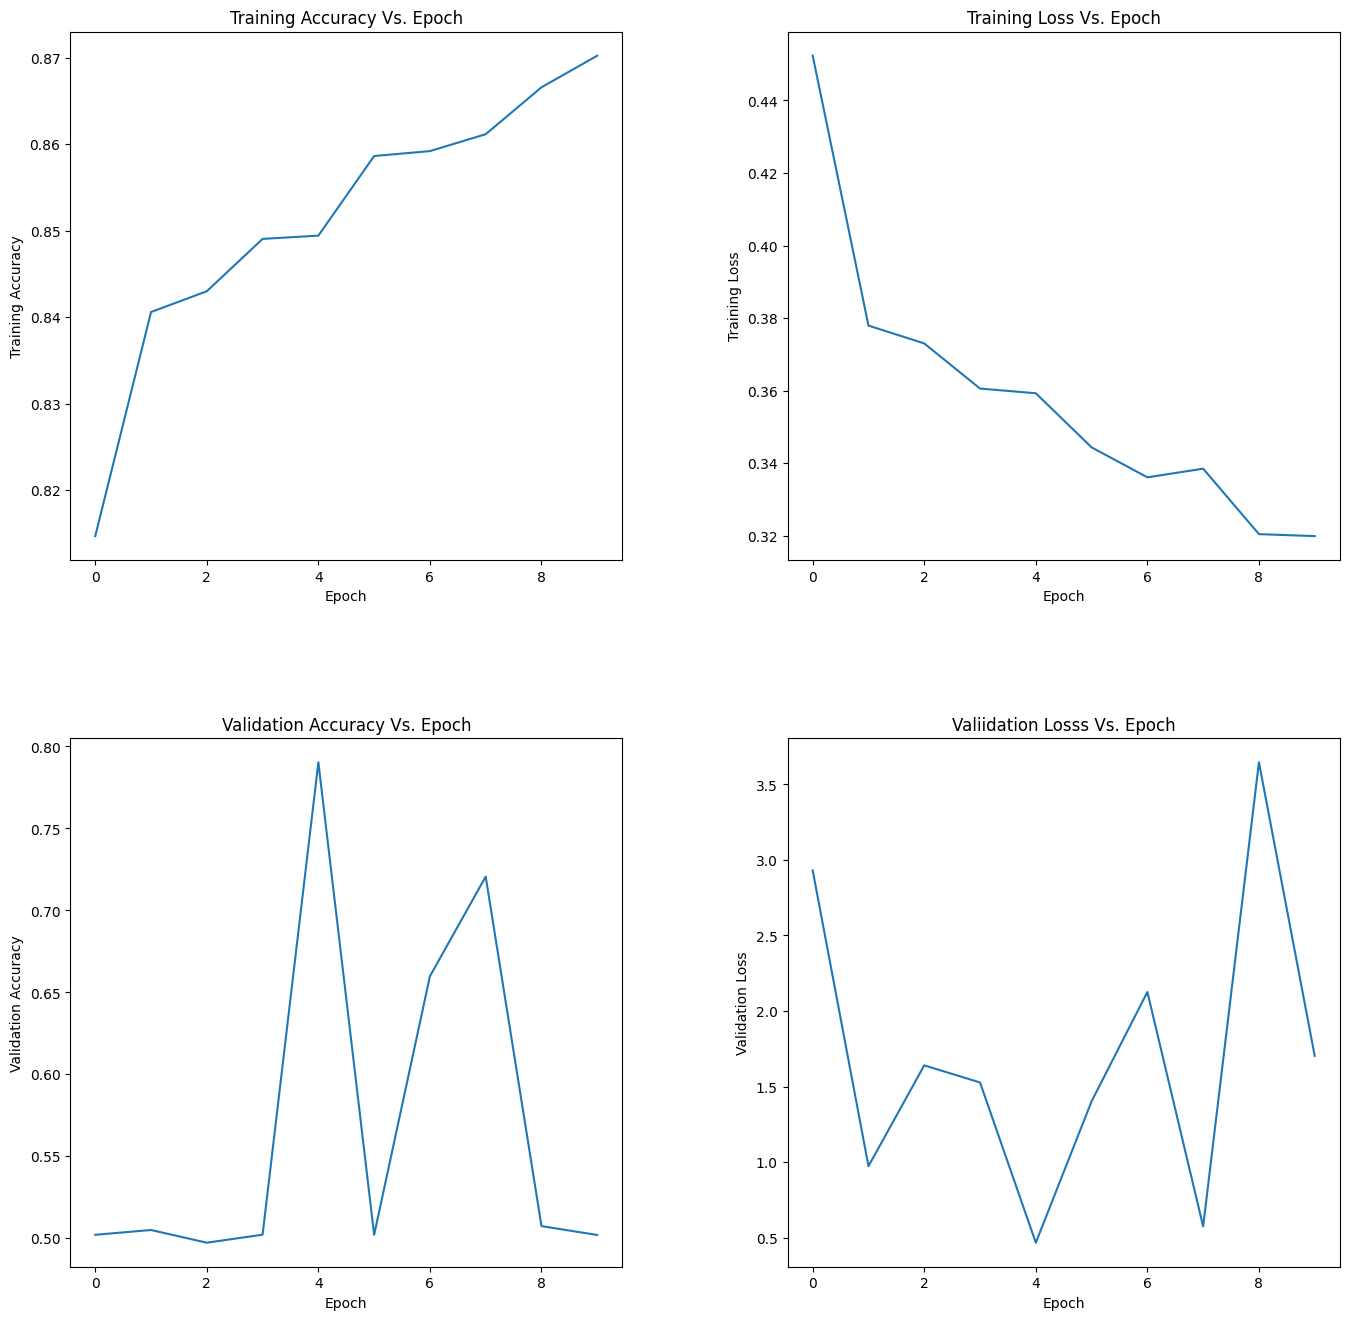

In [33]:
model_epochs=model3_epochs

for el in histories_list:
    plot_history(el)

Model 3 delivered **consistently strong training accuracy** across all three learning rates tested, with results hovering around **87%**. However, when evaluating **validation accuracy**, the model's performance proved to be **less reliable** compared to the earlier models. In all three cases, the validation accuracy was **notably lower**, indicating potential overfitting or instability introduced by the hyperparameter changes. This issue was **especially evident with a learning rate of 0.01**, where the validation results were highly erratic, **fluctuating significantly across epochs** and undermining the model's ability to generalize.

# 4. Conclusions

Across the three models developed for this project, we observed a clear progression in both architectural complexity and performance. **Model 1**, with its basic VGG-style structure, provided a strong baseline, achieving balanced training and validation accuracies around **86%**, suggesting solid generalization.

**Model 2** built upon this foundation by incorporating **batch normalization and dropout**, which helped boost **training accuracy to 90%** and **validation accuracy to 85%**, indicating a better fit and some resilience against overfitting.

**Model 3**, focused on **hyperparameter tuning**, achieved **high training accuracy (∼87%)** across all tested learning rates. However, it suffered in terms of **validation accuracy**, with results falling below those of previous models. This was especially problematic at a learning rate of **0.01**, where the model exhibited unstable behavior during training.

These outcomes highlight an important lesson in deep learning: **increased training accuracy doesn't always translate to better real-world performance**. Carefully balancing model complexity, regularization, and learning dynamics is essential for achieving robust generalization.

In [ ]:
def create_submission_csv(test_dir, model):
    images_test = pd.DataFrame({'id':os.listdir(test_dir)})
    
    # Scaling of test images to have pixel values in range [0-1]
    generator_test = ImageDataGenerator(rescale= 1.0 / 255)

    test_data = generator_test.flow_from_dataframe(
        dataframe = images_test,
        x_col='id',
        directory=test_dir,
        class_mode=None,
        batch_size=1,
        target_size=im_size,
        shuffle=False)

    # Predict using model
    predictions = model.predict(test_data, verbose = 1)
    
    # Submission dataframe
    submission_df = pd.DataFrame()
    submission_df['id'] = images_test['id'].apply(lambda x: x.split('.')[0])
    submission_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions.squeeze()))
    submission_df['label'].value_counts()
    submission_df.to_csv('submission.csv', index=False)
    
    return submission_df


In [ ]:
batch_size, im_size = 256, (96, 96)

submission_df = create_submission_csv(test_dir, model2)